In [71]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm, t
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**Problem 1**

In [ ]:
problem_1 = pd.read_csv('problem1.csv')
problem_1.head()


1A.

In [ ]:
mean_x = problem_1["X"].mean()
variance_x = problem_1["X"].var()
skewness_x = problem_1["X"].skew()
kurtosis_x = problem_1["X"].kurtosis()  # Excess Kurtosis

# Display the results
stats_summary = pd.DataFrame({
    "Mean": [mean_x],
    "Variance": [variance_x],
    "Skewness": [skewness_x],
    "Kurtosis": [kurtosis_x]
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Statistical Summary", dataframe=stats_summary)


1C.

In [ ]:
import numpy as np
from scipy.stats import norm, t

def calculate_aicc(log_likelihood, n, k):
    return 2 * k - 2 * log_likelihood + (2 * k * (k + 1)) / (n - k - 1)

# Fit normal distribution
mu_norm, sigma_norm = norm.fit(problem_1)
log_likelihood_norm = np.sum(norm.logpdf(problem_1, mu_norm, sigma_norm))
aicc_norm = calculate_aicc(log_likelihood_norm, len(problem_1), 2)

# Fit t-distribution
df_t, loc_t, scale_t = t.fit(problem_1)
log_likelihood_t = np.sum(t.logpdf(problem_1, df_t, loc_t, scale_t))
aicc_t = calculate_aicc(log_likelihood_t, len(problem_1), 3)

# Print results
print(f"Normal Distribution: μ = {mu_norm:.6f}, σ = {sigma_norm:.6f}")
print(f"AICc of Normal Distribution: {aicc_norm:.6f}")

print(f"T Distribution: ν = {df_t:.6f}, μ = {loc_t:.6f}, σ = {scale_t:.6f}")
print(f"AICc of T Distribution: {aicc_t:.6f}")


**Problem 2**

In [10]:
problem_2 = pd.read_csv('problem2.csv')
problem_2.head()

,x1,x2,x3,x4,x5
0,0.378172,0.508313,NaN,0.610538,NaN
1,0.858478,0.758142,NaN,NaN,NaN
2,-0.218954,-0.015334,-0.261880,NaN,-0.230148
3,-0.370442,-0.424702,-0.535312,NaN,-0.226233
4,0.717732,0.664195,NaN,NaN,0.914107


2A.

In [15]:
# Recalculate the pairwise covariance matrix for Problem 2
pairwise_cov_matrix = problem_2.cov()

# Display the covariance matrix
print("Pairwise Covariance Matrix:")
print(pairwise_cov_matrix)

Pairwise Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


2B.

In [16]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvals(pairwise_cov_matrix)

# Convert eigenvalues to DataFrame
eigenvalues_df = pd.DataFrame({"Eigenvalues": eigenvalues})

# Display eigenvalues
print("Eigenvalues of the Covariance Matrix:")
print(eigenvalues_df)

# Check if the matrix is Positive Semi-Definite (PSD)
if np.all(eigenvalues >= 0):
    print("The covariance matrix is Positive Semi-Definite (PSD).")
else:
    print("The covariance matrix is NOT Positive Semi-Definite (PSD).")


Eigenvalues of the Covariance Matrix:
   Eigenvalues
0     6.786706
1     0.834434
2    -0.310243
3     0.027978
4    -0.133232
The covariance matrix is NOT Positive Semi-Definite (PSD).


2C.

In [19]:
def _getAplus(A):
    """ Compute the nearest positive semi-definite matrix by replacing negative eigenvalues with zero. """
    eigvals, eigvecs = np.linalg.eigh(A)
    eigvals = np.maximum(eigvals, 0)  # Replace negative eigenvalues with zero
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def _getPS(A, W):
    """ Compute the weighted projection onto the set of positive semi-definite matrices. """
    W_sqrt = np.sqrt(W)
    inv_W_sqrt = np.linalg.inv(W_sqrt)
    return inv_W_sqrt @ _getAplus(W_sqrt @ A @ W_sqrt) @ inv_W_sqrt

def _getPu(A, W):
    """ Projection onto the set of matrices with unit diagonal (correlation matrix constraint). """
    A_proj = A.copy()
    np.fill_diagonal(A_proj, 1.0)  # Set diagonal elements to 1
    return A_proj

def wgtNorm(A, W):
    """ Compute the weighted Frobenius norm. """
    W_sqrt = np.sqrt(W)
    return np.sum((W_sqrt @ A @ W_sqrt) ** 2)

def higham_nearestPSD(pc, W=None, epsilon=1e-9, max_iter=100, tol=1e-9):
    """
    Compute the nearest positive semi-definite matrix using Higham's iterative method.
    """
    n = pc.shape[0]
    if W is None:
        W = np.diag(np.ones(n))  # Default weight matrix as identity

    deltaS = np.zeros_like(pc)
    Yk = pc.copy()

    # Convert covariance to correlation matrix if necessary
    if not np.allclose(np.diag(Yk), np.ones(n)):
        invSD = np.diag(1.0 / np.sqrt(np.diag(Yk)))
        Yk = invSD @ Yk @ invSD
    else:
        invSD = None

    Yo = Yk.copy()
    norml = np.finfo(float).max

    for i in range(max_iter):
        Rk = Yk - deltaS
        Xk = _getPS(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)

        norm = wgtNorm(Yk - Yo, W)
        min_eig_val = np.min(np.real(np.linalg.eigvals(Yk)))

        if norm - norml < tol and min_eig_val > -epsilon:
            print(f"Converged in {i+1} iterations.")
            break

        norml = norm

    else:
        print(f"Convergence failed after {max_iter} iterations")

    # Convert back to covariance matrix if needed
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        Yk = invSD @ Yk @ invSD

    return Yk


pairwise_cov_matrix_psd = higham_nearestPSD(pairwise_cov_matrix.to_numpy())
print("PSD calculated by Higham's method':\n", pd.DataFrame(pairwise_cov_matrix_psd, index = problem_2.columns, columns = problem_2.columns))


Converged in 56 iterations.
PSD calculated by Higham's method':
           x1        x2        x3        x4        x5
x1  1.470484  1.332361  0.884378  1.627602  1.399556
x2  1.332361  1.252078  0.619028  1.450604  1.214450
x3  0.884378  0.619028  1.272425  1.076846  1.059658
x4  1.627602  1.450604  1.076846  1.814469  1.577928
x5  1.399556  1.214450  1.059658  1.577928  1.396186


In [20]:
def near_psd_rebonato(A: np.ndarray, epsilon=0.0)-> np.ndarray:
    """
    Find the nearest positive semi-definite matrix using the Rebonato & Jackel method.
    """
    n = A.shape[0]
    out = A.copy()

    # Check if the matrix is already a correlation matrix (diagonal elements = 1)
    if not np.allclose(np.diag(out), np.ones(n)):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(out)
    eigvals = np.maximum(eigvals, epsilon)  # Ensure non-negative eigenvalues

    T = 1.0 / (eigvecs ** 2 @ eigvals)
    T = np.diag(np.sqrt(T))
    L = np.diag(np.sqrt(eigvals))
    B = T @ eigvecs @ L
    out = B @ B.T

    # Restore covariance scaling
    if 'invSD' in locals():
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD

    return out
A_psd_rebonato = near_psd_rebonato(pairwise_cov_matrix)
print("PSD calculated by Rebonato & Jackel's method:\n", pd.DataFrame(A_psd_rebonato, index = problem_2.columns, columns = problem_2.columns))


PSD calculated by Rebonato & Jackel's method:
           x1        x2        x3        x4        x5
x1  1.470484  1.327009  0.842583  1.624464  1.364833
x2  1.327009  1.252078  0.555421  1.433109  1.165906
x3  0.842583  0.555421  1.272425  1.052789  1.060424
x4  1.624464  1.433109  1.052789  1.814469  1.544993
x5  1.364833  1.165906  1.060424  1.544993  1.396186


2D.

In [21]:
problem_2_overlapping = problem_2.dropna()
overlapping_cov_matrix = problem_2_overlapping.cov()
print("overlapping data covariance matrix:")
print(overlapping_cov_matrix)

overlapping data covariance matrix:
          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


**Problem 3**

In [25]:
problem_3 = pd.read_csv('problem3.csv')
problem_3.head()

,x1,x2
0,0.116393,0.290704
1,0.121387,-0.042551
2,0.004184,0.040375
3,-0.129885,-0.013411
4,-0.076053,0.077160


3A

In [26]:
mu_estimated = problem_3.mean()
cov_estimated = problem_3.cov()

In [28]:
mu_estimated

x1    0.046002
x2    0.099915
dtype: float64

In [30]:
cov_estimated.values

array([[0.0101622 , 0.00492354],
       [0.00492354, 0.02028441]])

3C.

Conditional mean of X2 | X1=0.6: 0.36852519860894933
Conditional variance of X2 | X1=0.6: 0.01787368731900266


/var/folders/qq/5mjftsdj0dx0q3ssxy482zkh0000gn/T/ipykernel_18591/1756408608.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z1 = (X1 - mu_estimated[0]) / L11
/var/folders/qq/5mjftsdj0dx0q3ssxy482zkh0000gn/T/ipykernel_18591/1756408608.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X2 = L21 * Z1 + L22 * Z2 + mu_estimated[1]


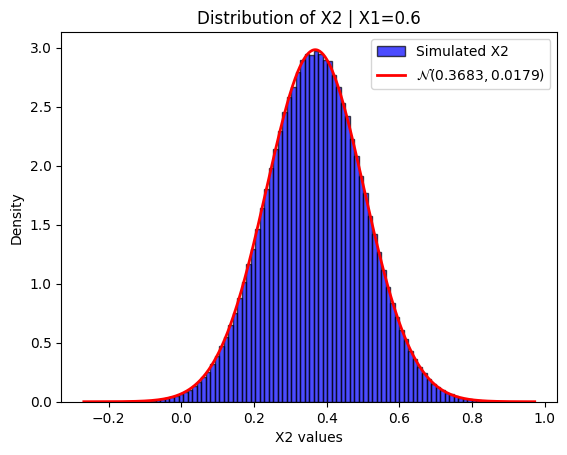

In [43]:
L = np.linalg.cholesky(cov_estimated)

X1 = 0.6
L11 = L[0, 0]
L21 = L[1, 0]
L22 = L[1, 1]


Z1 = (X1 - mu_estimated[0]) / L11

num_samples = 1000000 
Z2 = np.random.normal(0, 1, num_samples)

X2 = L21 * Z1 + L22 * Z2 + mu_estimated[1]

print(f"Conditional mean of X2 | X1=0.6: {np.mean(X2)}")
print(f"Conditional variance of X2 | X1=0.6: {np.var(X2)}")


mu_cond = 0.3683
sigma_cond = np.sqrt(0.0179)
x = np.linspace(min(X2), max(X2), 500)
pdf = norm.pdf(x, mu_cond, sigma_cond)

plt.hist(X2, bins=100, density=True, alpha=0.7, color='blue', edgecolor='k', label="Simulated X2")
plt.plot(x, pdf, color='red', lw=2, label=r"$\mathcal{N}(0.3683, 0.0179)$")

plt.title("Distribution of X2 | X1=0.6")
plt.xlabel("X2 values")
plt.ylabel("Density")
plt.legend()

**Problem 4**

In [69]:
problem_4 = pd.read_csv('problem4.csv')
simulated_y = pd.Series(problem_4['y'])

4A.

Text(0.5, 1.0, 'PACF of MA(3) Residuals')

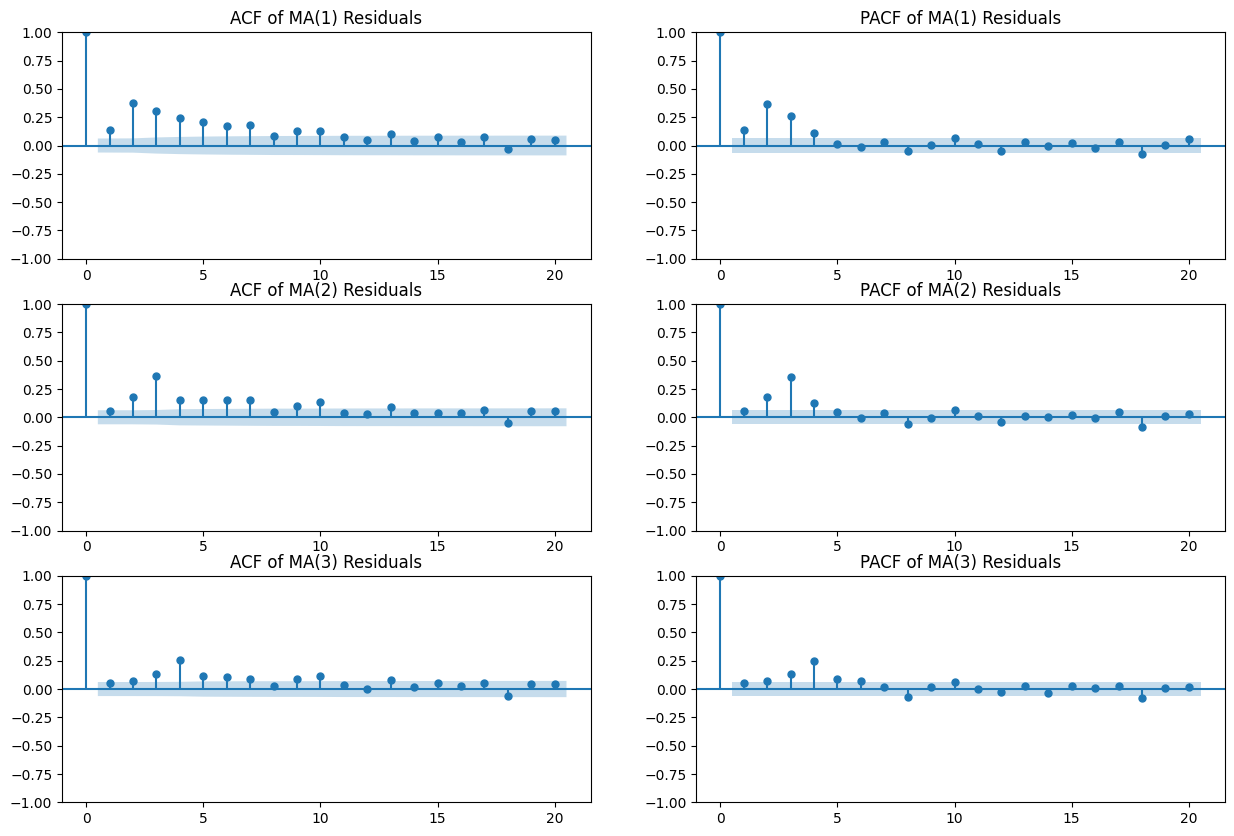

In [72]:
ma1_mdl = ARIMA(simulated_y, order=(0, 0, 1)).fit()
ma1_resid = ma1_mdl.resid
ma2_mdl = ARIMA(simulated_y, order=(0, 0, 2)).fit()
ma2_resid = ma2_mdl.resid
ma3_mdl = ARIMA(simulated_y, order=(0, 0, 3)).fit()
ma3_resid = ma3_mdl.resid

fig, axes = plt.subplots(3, 2, figsize = (15, 10))
plot_acf(ma1_resid, ax=axes[0, 0], lags=20)
axes[0, 0].set_title("ACF of MA(1) Residuals")
plot_pacf(ma1_resid, ax=axes[0, 1], lags=20)
axes[0, 1].set_title("PACF of MA(1) Residuals")

plot_acf(ma2_resid, ax=axes[1, 0], lags=20)
axes[1, 0].set_title("ACF of MA(2) Residuals")
plot_pacf(ma2_resid, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("PACF of MA(2) Residuals")

plot_acf(ma3_resid, ax=axes[2, 0], lags=20)
axes[2, 0].set_title("ACF of MA(3) Residuals")
plot_pacf(ma3_resid, ax=axes[2, 1], lags=20)
axes[2, 1].set_title("PACF of MA(3) Residuals")

4B.

Text(0.5, 1.0, 'PACF of AR(3) Residuals')

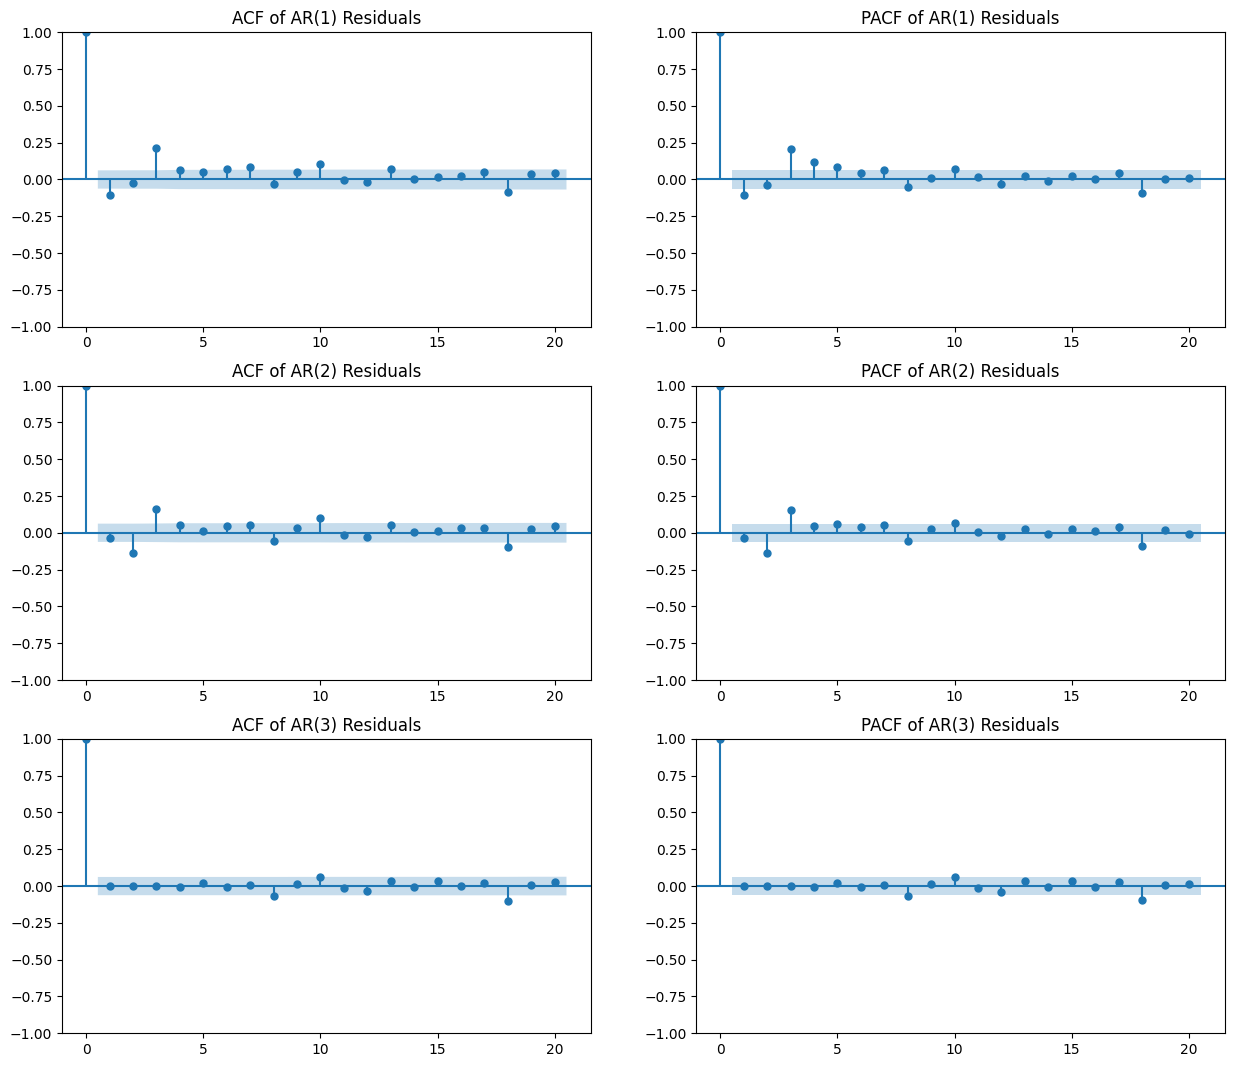

In [73]:
ar1_mdl = ARIMA(simulated_y, order=(1, 0, 0)).fit()
ar1_resid = ar1_mdl.resid
ar2_mdl = ARIMA(simulated_y, order=(2, 0, 0)).fit()
ar2_resid = ar2_mdl.resid
ar3_mdl = ARIMA(simulated_y, order=(3, 0, 0)).fit()
ar3_resid = ar3_mdl.resid

fig, axes = plt.subplots(3, 2, figsize = (15, 13))
plot_acf(ar1_resid, ax=axes[0, 0], lags=20)
axes[0, 0].set_title("ACF of AR(1) Residuals")
plot_pacf(ar1_resid, ax=axes[0, 1], lags=20)
axes[0, 1].set_title("PACF of AR(1) Residuals")

plot_acf(ar2_resid, ax=axes[1, 0], lags=20)
axes[1, 0].set_title("ACF of AR(2) Residuals")
plot_pacf(ar2_resid, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("PACF of AR(2) Residuals")

plot_acf(ar3_resid, ax=axes[2, 0], lags=20)
axes[2, 0].set_title("ACF of AR(3) Residuals")
plot_pacf(ar3_resid, ax=axes[2, 1], lags=20)
axes[2, 1].set_title("PACF of AR(3) Residuals")


4C.

Text(0.5, 1.0, 'PACF')

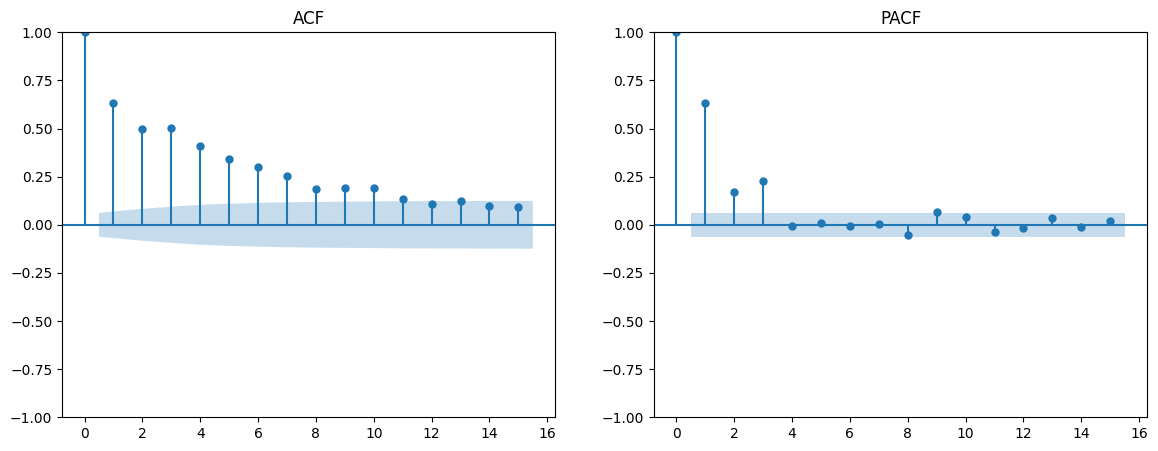

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(simulated_y, ax=axes[0], lags=15)  
axes[0].set_title("ACF")
plot_pacf(simulated_y, ax=axes[1], lags=15, method="ywm") 
axes[1].set_title("PACF")


4D.

In [82]:
smallest_aic = np.inf
best_order = None

for p in range(1, 11):
    model = ARIMA(simulated_y, order=(p, 0, 0)).fit()
    aic = model.aic
    if aic < smallest_aic:
        smallest_aic = aic
        best_order = p

print(f'Best order is {best_order}')

Best order is 3


**Problem 5**

In [38]:
problem_5 = pd.read_csv('DailyReturn.csv')
problem_5.head()

,Date,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
0,2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,...,0.036001,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626
1,2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,...,-0.000287,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714
2,2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,...,0.021641,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163
3,2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,...,-0.018277,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713
4,2023-01-10,0.007013,0.004456,0.017981,0.007617,0.028732,0.027188,0.004544,-0.003398,-0.007681,...,0.012030,0.000000,0.017410,0.005637,0.007190,0.009871,0.015082,-0.000086,0.013660,0.020539


5A

In [37]:
def pca_analysis(df, lambda_factor):
    
    n = len(df)  
    weights = np.zeros(n)  
    cumulative_w = np.zeros(n)  
    total_weights = 0.0  

    for i in range(n):
        weights[i] = (1 - lambda_factor) * lambda_factor ** i
        total_weights += weights[i]
        cumulative_w[i] = total_weights

    weights /= total_weights  
    
    weights = weights[::-1]  
    df = df.loc[:, df.columns != "Date"]
    means = (df.T * weights).sum(axis=1)  
    
    mean_centered = df - means  

    variables = df.columns
    cov_matrix = pd.DataFrame(index = variables, columns = variables, dtype = float)

    for i in variables:
        for j in variables:
            cov_matrix.loc[i, j] = np.sum(weights * mean_centered[i] * mean_centered[j])


    pca = PCA()
    pca.fit(cov_matrix)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return cumulative_variance



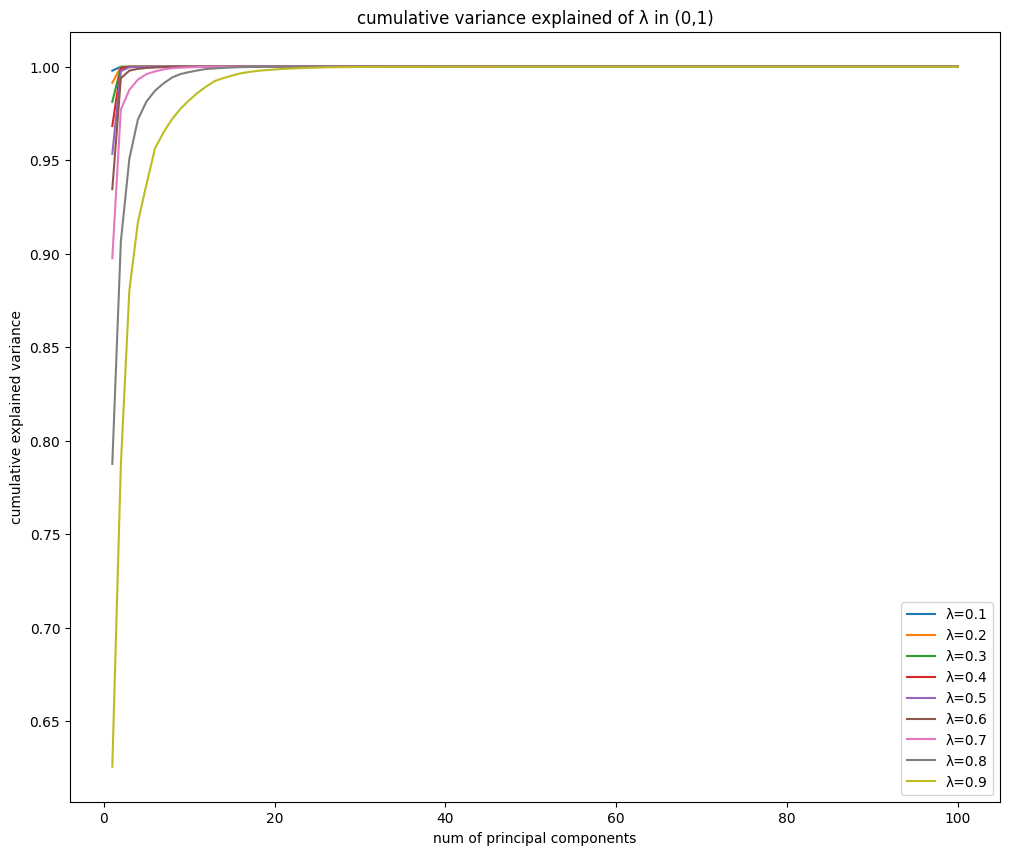

In [40]:
cumulative_variances = {}

lambda_values = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
for lambda_factor in lambda_values:
    cumulative_variance = pca_analysis(problem_5, lambda_factor)
    cumulative_variances[lambda_factor] = cumulative_variance
plt.figure(figsize=(12, 10))
for lambda_factor, cumulative_variance in cumulative_variances.items():
    plt.plot(
        range(1, len(cumulative_variance) + 1),
        cumulative_variance,
        label=f"λ={lambda_factor}",
    )
plt.title("cumulative variance explained of λ in (0,1)")
plt.xlabel("num of principal components")
plt.ylabel("cumulative explained variance")
plt.legend()

**Problem 6**

In [75]:
problem_6 = pd.read_csv('problem6.csv')
problem_6.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,x500
0,0.005315,0.000215,-0.000777,0.000418,-0.000687,0.000166,0.000935,-0.000445,0.000826,0.000146,...,0.001210,-0.000365,0.000155,-0.000881,-0.000284,-0.000149,0.000021,0.000237,0.001169,-0.000095
1,0.000215,0.001781,0.000094,-0.000109,-0.000438,0.000523,-0.000803,0.000242,0.000596,0.000129,...,0.000212,0.000256,-0.000106,-0.000080,0.000053,-0.000190,0.000009,0.000370,0.000707,0.000139
2,-0.000777,0.000094,0.004925,0.000320,-0.000592,0.000418,-0.000195,0.000543,0.001143,-0.000326,...,-0.000634,-0.000883,-0.000068,-0.000492,0.000222,-0.000761,-0.000269,-0.000335,0.000360,-0.000124
3,0.000418,-0.000109,0.000320,0.002545,-0.000323,-0.000106,0.000165,-0.000077,-0.000186,-0.000830,...,-0.000069,-0.000187,-0.000157,-0.000183,-0.000380,0.000310,0.000172,0.000148,0.000761,0.000240
4,-0.000687,-0.000438,-0.000592,-0.000323,0.009133,-0.001379,-0.002163,-0.000677,-0.000217,0.000413,...,0.001167,0.000394,-0.000137,0.000604,-0.000234,0.001203,0.000028,0.000201,-0.001461,0.000078


In [87]:
def compute_covariance_matrix(df):
    """ Compute the covariance matrix from the dataset. """
    return df.cov().to_numpy()

def nearest_positive_semi_definite(matrix):
    """ Adjusts a covariance matrix to be the nearest positive semi-definite matrix."""
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals = np.maximum(eigvals, 1e-8)  # Replace negative eigenvalues with a small positive value
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def cholesky_simulation(cov_matrix, num_samples=10000):
    """ Simulates multivariate normal data using the Cholesky decomposition. """
    try:
        L = np.linalg.cholesky(cov_matrix)
    except np.linalg.LinAlgError:
        cov_matrix = nearest_positive_semi_definite(cov_matrix)
        L = np.linalg.cholesky(cov_matrix)
    z = np.random.randn(cov_matrix.shape[0], num_samples)
    return L @ z


cov_matrix = compute_covariance_matrix(problem_6)
start = time.time()
cholesky_samples = cholesky_simulation(cov_matrix)
time_cholesky = time.time() - start
cov_cholesky = np.cov(cholesky_samples)

# Compute Frobenius norm difference
frobenius_cholesky = np.linalg.norm(cov_cholesky - cov_matrix, 'fro')



print("cholesky_simulation: ")
print("Frobenius Norm Difference",frobenius_cholesky )
print("Execution Time: ", round(time_cholesky, 6), 's')


cholesky_simulation: 
Frobenius Norm Difference 1.4441344036190884e-06
Execution Time:  0.074136 s


In [88]:
def pca_simulation(cov_matrix, num_samples=10000, variance_threshold=0.75):
    """ Simulates multivariate normal data using PCA with a given variance threshold. """
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[sorted_indices], eigvecs[:, sorted_indices]
    
    cumulative_variance = np.cumsum(eigvals) / np.sum(eigvals)
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    selected_vectors = eigvecs[:, :num_components]
    selected_values = np.diag(np.sqrt(eigvals[:num_components]))
    
    z = np.random.randn(num_components, num_samples)
    return selected_vectors @ selected_values @ z

start = time.time()
pca_samples = pca_simulation(cov_matrix)
time_pca = time.time() - start

cov_pca = np.cov(pca_samples)
frobenius_pca = np.linalg.norm(cov_pca - cov_matrix, 'fro')


print("pca: ")
print("Frobenius Norm Difference",frobenius_pca )
print("Execution Time: ", round(time_pca, 6), 's')


pca: 
Frobenius Norm Difference 5.789022296050302e-06
Execution Time:  0.028307 s


6D.

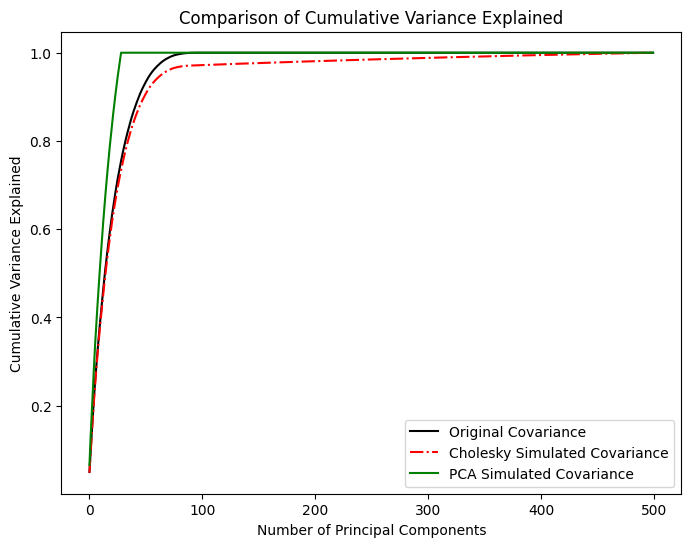

In [93]:
# Compare cumulative variance explained
def compute_cumulative_variance(cov_matrix):
    original_eigenvalues = np.linalg.eigvalsh(cov_matrix)[::-1]  # Descending order
    cumulative_original = np.cumsum(original_eigenvalues) / np.sum(original_eigenvalues)
    return cumulative_original
cumulative_variance_original = compute_cumulative_variance(cov_matrix)
cumulative_variance_cholesky = compute_cumulative_variance(cov_cholesky)
cumulative_variance_pca = compute_cumulative_variance(cov_pca)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_original, label="Original Covariance", color = 'black')
plt.plot(cumulative_variance_cholesky, label="Cholesky Simulated Covariance", linestyle = '-.', color = 'red')
plt.plot(cumulative_variance_pca, label="PCA Simulated Covariance", color = 'green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.title("Comparison of Cumulative Variance Explained")
plt.show()

6E.

In [94]:
print(f'time cost by Cholesky Root method: {time_cholesky:.4f} s')
print(f'time cost by PCA method: {time_pca:.4f} s')

time cost by Cholesky Root method: 0.0741 s
time cost by PCA method: 0.0283 s
